In [14]:
import discogslearner
extracter = discogslearner.Extracter()

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

In [16]:
extracter.createOneHotFiles("Data")




ValueError: Invalid file path or buffer object type: <class 'method'>

In [1]:
import discogslearner
extracter = discogslearner.Extracter()
idx = extracter.getIndexes("Data/releases.tsv", minimum_values=10_000)

KeyboardInterrupt: 

In [63]:
import pandas as pd
import numpy as np
file = "Data/releases.tsv"
columns = ["Country", "Formats", "Styles"]
data = pd.read_csv(file, sep = "\t")[columns]

In [53]:
def getColumns(series, percentage):
    vals = series.astype(str).str.split(";").explode()
    counts = vals.value_counts() 
    relative = counts * 100 / sum(counts)
    id = min(np.where(np.floor(np.cumsum(relative) >= percentage))[0])
    return counts.index[0:id]


cols = {_: getColumns(data[_], 90) for _ in columns}

In [61]:
len(idx)

3071635

In [65]:
import numpy as np
import os
from tqdm import tqdm

def parse(x, output, max_value, columns):

    x = pd.get_dummies(x.astype(str).str.split(";").explode())
    x = x.groupby(level = 0).sum().fillna(0).drop(columns = 'nan', errors = "ignore")
    
    all = pd.Series(columns).astype(str)
    cols = list(all.loc[~all.isin(x.columns)])
    remained = pd.DataFrame(0, index = x.index, columns=cols)
    x = pd.concat([x, remained], axis = 1)[columns]
    x = x.iloc[np.where(x.sum(axis = 1) > 0)]
    x.to_csv(output, mode = "a", sep = "\t", header = False)

def parseColumn(data, category, cols, folder, groupSize = 10_000):
    columns = cols[category]
    groups = data.index // groupSize
    tqdm.pandas(desc = "Parsing column " + category, total = len(data.index) // groupSize)

    max_value = int(data[category].groupby(groups).apply(
        lambda x: x.astype(str).str.split(";").explode().astype(float).max()
    ).max())
    
    output = os.path.join(folder, category + ".tsv")
    header = pd.DataFrame(columns = columns)
    header.to_csv(output, mode = "w", sep = "\t")
    data.groupby(groups).progress_apply(lambda x: parse(x[category], output, max_value, columns))


for column in columns:
    parseColumn(data, column, cols, "Data")

Parsing column Styles: 100%|██████████| 410/410 [03:31<00:00,  1.94it/s]


In [9]:
pd.read_csv("Data/releases.tsv", sep = "\t", usecols = ["Year", "Tracks"]).loc[idx]

,Year,Tracks
0,1999,6
1,1998,4
2,1999,14
3,1999,12
4,1995,5
...,...,...
4101313,2022,13
4101314,2019,10
4101315,2004,2
4101316,2019,6


In [1]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

import pandas as pd
import numpy as np

idx = set.intersection(
    set(pd.read_csv("Data/Styles.tsv", index_col=0, sep = "\t").index),
    set(pd.read_csv("Data/Country.tsv", index_col=0, sep = "\t").index),
    set(pd.read_csv("Data/Formats.tsv", index_col=0, sep = "\t").index)
)

In [16]:
df = pd.concat([
    pd.read_csv("Data/Styles.tsv", index_col=0, sep = "\t").loc[idx],
    pd.read_csv("Data/Country.tsv", index_col=0, sep = "\t").loc[idx],
    pd.read_csv("Data/Formats.tsv", index_col=0, sep = "\t").loc[idx],
    pd.read_csv("Data/releases.tsv", sep = "\t", usecols = ["Year", "Tracks"]).loc[idx]
], axis = 1)

In [17]:
df = df.replace({"Year": {0: df.Year.median()}, "Tracks": {0: df.Tracks.median()}})
df.Tracks = df.Tracks.clip(lower = 1, upper = 10)
df.Year = df.Year.clip(lower = 1900, upper = 2022)
pca = PCA(n_components=20)
df = preprocessing.StandardScaler().fit_transform(df)

pd.DataFrame(pca.fit_transform(df).round(4)).set_index(pd.Index(idx)).to_csv("Data/Release_PCA.tsv", sep = "\t")


In [15]:
import pandas as pd
import numpy as np
from tqdm import tqdm

df = pd.read_csv("Data/Release_PCA.tsv", index_col=0, sep = "\t")


for column in ["Companies", "Artists"]: # "Labels", 
    file = "Data/releases.tsv"
    data = pd.read_csv(file, sep = "\t")[column].loc[df.index]
    data = data.str.split(";").explode().dropna().astype(int)



    #tqdm.pandas(desc = "Parsing " + column, total = len(data.value_counts().index))

    # translation = data.groupby(data).progress_apply(
    #     lambda x: pd.DataFrame(df.loc[x.index].mean(axis = 0)).transpose()
    # ).droplevel(1)
    # translation.to_csv(f"Data/{column}_PCA.tsv", sep = "\t")

    file = f"Data/{column}_PCA.tsv"
    translation = pd.read_csv(file, sep = "\t").set_index(column)
    tqdm.pandas(desc = "Merging into releases " + column, total = len(data.index))
    data.groupby(level = 0).progress_apply(
        lambda x:  pd.DataFrame(translation.loc[x].mean(axis = 0)).transpose()
    ).droplevel(1).to_csv(f"Data/{column}_release_PCA.tsv", sep = "\t")

Merging into releases Artists:  15%|█▌        | 3071635/20441527 [57:37<5:25:52, 888.37it/s] 


In [12]:
file = "Data/releases.tsv"
column = "Labels"
data = pd.read_csv(file, sep = "\t")[column].loc[df.index]
data = data.str.split(";").explode().dropna().astype(int)

file = f"Data/{column}_PCA.tsv"
translation = pd.read_csv(file, sep = "\t").set_index(column)

In [13]:
translation.loc[data.iloc[1]]

0     0.624978
1    -1.196954
2     0.553850
3    -0.966687
4    -0.955313
5     0.330602
6    -1.069704
7     0.429997
8    -0.386315
9     0.157345
10    0.610805
11    0.042243
12    0.175466
13   -0.188349
14   -1.204493
15    0.152045
16    1.074470
17   -0.416069
18   -0.473423
19   -0.488434
Name: 5, dtype: float64

In [89]:
data

0           507025
0              239
0                1
1               27
1               26
            ...   
4101316    3686634
4101316       7875
4101316      81957
4101316     157565
4101317    7586934
Name: Artists, Length: 20441527, dtype: object

1    0
1    1
1    2
2    3
2    1
dtype: int64

,from,to
0,0,1
1,0,2
2,1,2
3,3,1


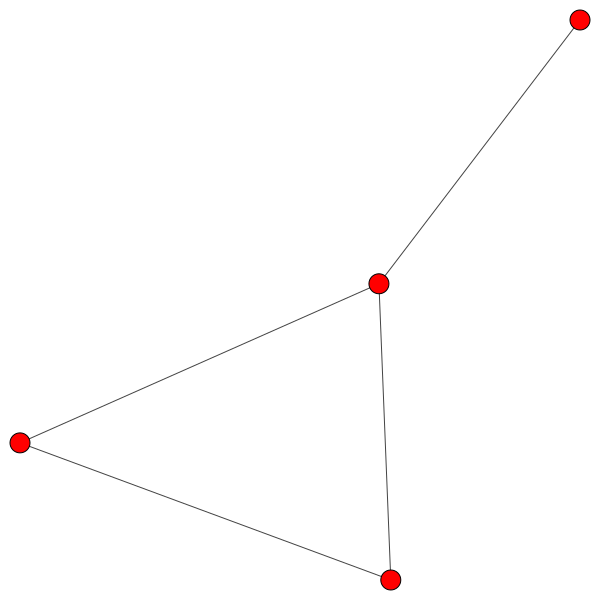

In [13]:
from itertools import combinations
import pandas as pd
import igraph as ig

df = pd.Series(data = [0, 1, 2, 3, 1], index = [1,1,1,2,2])
display(df)
edges = pd.DataFrame(df.groupby(level=0).apply(
    lambda x: list(combinations(x, 2))
).explode().to_list(), columns = ["from", "to"])
display(edges)


g = ig.Graph.DataFrame(edges, directed = False)
g.get_vertex_dataframe()
ig.plot(g)

In [1]:
import pandas as pd
from tqdm import tqdm
from itertools import combinations
import igraph as ig
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 20]

column = "Styles"
file = "Data/releases.tsv"
artist = pd.read_csv(file, sep = "\t")["Artists"]

In [3]:
subset = artist.head(500000).str.split(";").explode()

subset = subset.astype(int)

subset = np.argsort(np.argsort(subset.astype('category')))


edges = pd.DataFrame(subset.groupby(level=0).apply(
    lambda x: list(combinations(x, 2))
).explode().to_list(), columns = ["from", "to"])

edges = edges.loc[~edges["from"].isna()]
edges = edges.loc[~edges["to"].isna()]
edges["from"] = edges["from"].astype(int)
edges["to"] = edges["to"].astype(int)

g = ig.Graph.DataFrame(edges, directed = False)
ig.config['plotting.backend'] = 'matplotlib'


In [3]:

groupSize = 5000
tqdm.pandas(desc = "Mapping database to PCA space", total = len(artist.index) // groupSize)

def edgeDf(df):
    pd.DataFrame(df.groupby(level=0).apply(
        lambda x: list(combinations(x, 2))
    ).explode().to_list(), columns = ["from", "to"])

edges = artist.groupby(artist.index // groupSize).progress_apply(
    lambda x: edgeDf(x.str.split(";").explode())
)

Mapping database to PCA space:   0%|          | 3/820 [00:00<02:35,  5.24it/s]


ValueError: Shape of passed values is (309639, 1), indices imply (309639, 2)